In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# data base path
database_path = "Resources/hawaii.sqlite"

In [4]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# inspector function
inspector = inspect(engine)

# Collect names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Use inspector to print column names within the 'Measurement' table w/ types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Use inspector to print column names within the 'station' table w/ types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Determine how many dates are recorded in total
session.query(func.count(Measurement.date)).all()

[(19550)]

In [16]:
# Find the most recent date in the data set.
earlieststr = session.query(Measurement.date).order_by(Measurement.date).first()
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earlieststr[0]}, Latest: {lateststr[0]}")

Earliest: 2010-01-01, Latest: 2017-08-23


In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recentdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
querydate = dt.date(recentdate.year -1, recentdate.month, recentdate.day)
querydate

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(queryresult, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.dropna(how='any')
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


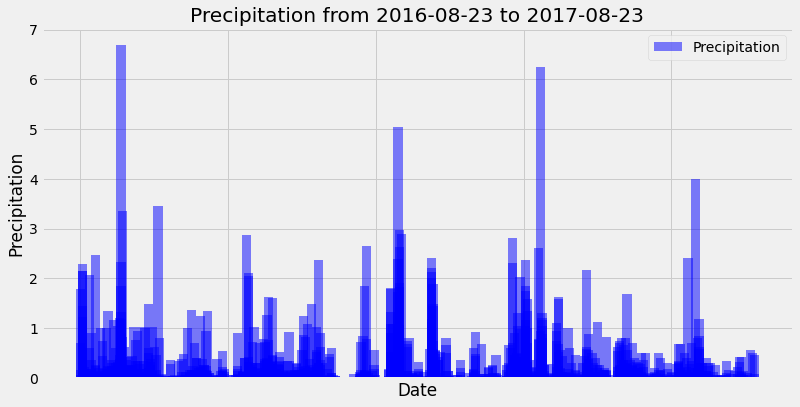

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
x = precipitation_df.index.tolist()
y = precipitation_df['Precipitation'].tolist()

plt.figure(figsize= (12,6))
plt.bar(x,y,width = 5, color='b', alpha=0.5, align="center", label='Precipitation')
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
sel = [Measurement.station, func.count(Measurement.id)]

# List the stations and the counts in descending order.
activestations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
mostactivestation_data = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestation_data

(54.0, 85.0, 71.66378066378067)

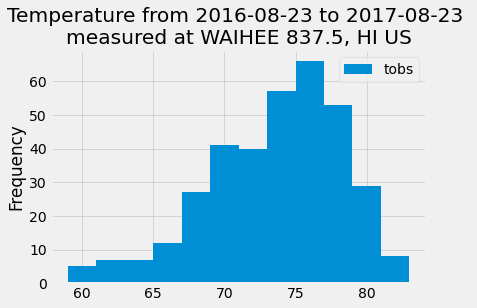

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= querydate).all()

temperatures = list(np.ravel(queryresult))

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]

queryresult = session.query(*sel).all()

stations_df = pd.DataFrame(queryresult, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

stationname = stations_df.loc[stations_df["Station"] == activestations[0][0], "Name"].tolist()[0]

plt.hist(temperatures, bins=12, rwidth=1.0, label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {querydate} to {lateststr[0]} \nmeasured at {stationname}")
plt.legend()

# Close session

In [34]:
# Close Session
session.close()